In [1]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"abhishekmalpotra","key":"f499338afe291ac267419d88908d7503"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d dev523/leaf-disease-detection-dataset

100% 1.34G/1.34G [00:48<00:00, 40.8MB/s]
100% 1.34G/1.34G [00:48<00:00, 29.9MB/s]


In [5]:
!unzip leaf-disease-detection-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: dataset/train/Tomato___Tomato_Yellow_Leaf_Curl_Virus/b58223cf-fca6-4032-84f1-7bdea7c9e844___UF.GRC_YLCV_Lab 03023.JPG  
  inflating: dataset/train/Tomato___Tomato_Yellow_Leaf_Curl_Virus/b5d66ba6-f0b2-466a-af7b-7782365316cc___UF.GRC_YLCV_Lab 03343.JPG  
  inflating: dataset/train/Tomato___Tomato_Yellow_Leaf_Curl_Virus/b5df724d-f326-4d82-b39d-bf35f5715333___UF.GRC_YLCV_Lab 02719.JPG  
  inflating: dataset/train/Tomato___Tomato_Yellow_Leaf_Curl_Virus/b5feffb4-8676-41fa-9b89-6496c97effc8___YLCV_GCREC 2352.JPG  
  inflating: dataset/train/Tomato___Tomato_Yellow_Leaf_Curl_Virus/b613012a-7de8-4891-9d9a-0f075e4fc9f1___YLCV_NREC 0094.JPG  
  inflating: dataset/train/Tomato___Tomato_Yellow_Leaf_Curl_Virus/b62b0c7e-942d-477b-9c11-321c6b0964e2___UF.GRC_YLCV_Lab 09491.JPG  
  inflating: dataset/train/Tomato___Tomato_Yellow_Leaf_Curl_Virus/b633d977-9372-4286-9a34-792b7fae45b8___YLCV_GCREC 2622.JPG  
  inflating: dataset/train/Tomato___T

In [6]:
# Import necessary libraries
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [7]:
# Define constants
IMAGE_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 5
TRAIN_FOLDER = 'dataset/train'
VAL_FOLDER = 'dataset/test'
MODEL_PATH = 'leaf_disease_model.h5'

In [8]:
# Function to load dataset using ImageDataGenerator
def load_data():
    # Create ImageDataGenerator for training data with data augmentation
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True
    )

    # Create ImageDataGenerator for validation data without data augmentation
    val_datagen = ImageDataGenerator(rescale=1./255)

    # Generate train data from directory
    train_generator = train_datagen.flow_from_directory(
        TRAIN_FOLDER,
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='sparse'
    )

    # Generate validation data from directory
    val_generator = val_datagen.flow_from_directory(
        VAL_FOLDER,
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='sparse'
    )

    return train_generator, val_generator

In [9]:
# Function to generate countplot
def count_plot(x, title, xlabel, ylabel, width, length, order=None, rotation=False, palette='winter'):
    plt.figure(figsize=(width, length))
    sns.countplot(x=x, palette=palette, order=order)
    plt.title(title, fontsize=25)
    if rotation:
        plt.xticks(rotation='vertical')
    plt.xlabel(xlabel, fontsize=20)
    plt.ylabel(ylabel, fontsize=20)
    plt.show()

In [10]:
# Function to plot label distribution
def plot_label_distribution(generator, title):
    label_dist = pd.DataFrame(generator.labels, columns=['label'])
    count_plot(label_dist['label'], title, xlabel='Class', ylabel='Count', width=15, length=8, rotation=True, palette='winter')

In [11]:
# Function for EDA
def eda(train_generator, val_generator):
    num_classes = len(train_generator.class_indices)
    num_train_images = train_generator.samples
    num_val_images = val_generator.samples

    print(f"Our data contains {num_classes} classes")
    print(f"Our training data has {num_train_images} images")
    print(f"Our validation data has {num_val_images} images")

    # Shape of train and test data
    print(f"Shape of train data: {train_generator.image_shape}")
    print(f"Shape of validation data: {val_generator.image_shape}")

    # Label distribution of train dataset
    plot_label_distribution(train_generator, "Label distribution of train dataset")

    # Label distribution of validation data
    plot_label_distribution(val_generator, "Label distribution of validation dataset")

In [12]:
# Function to create the model
def create_model(train_generator):
    # Load MobileNetV2 with pre-trained weights and exclude the top layer
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

    # Freeze the layers of the base model to use pre-trained weights
    for layer in base_model.layers:
        layer.trainable = False

    # Add custom layers for the task
    x = base_model.output
    # Add global average pooling layer
    x = layers.GlobalAveragePooling2D()(x) 
    # Add a dense layer with ReLU activation 
    x = layers.Dense(1024, activation='relu')(x)  
    x = layers.Dropout(0.5)(x)  # Add a dropout layer with a 50% dropout rate
    # Add output layer with softmax activation
    predictions = layers.Dense(len(train_generator.class_indices), activation='softmax')(x)
    # Create the final model by combining the base and custom layers
    model = models.Model(inputs=base_model.input, outputs=predictions)
    return model

In [13]:
# Function to train the model
def train_model(model, train_generator, val_generator):
  # Compile the model using Adam optimizer, sparse categorical crossentropy loss, and accuracy metric
  model.compile(optimizer=optimizers.Adam(learning_rate=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
  # Train the model on the train and validation data
  history = model.fit(train_generator,
                    epochs=EPOCHS,
                    validation_data=val_generator,
                    verbose=1)
  return history

In [14]:
#Function to plot the accuracy and loss during validation plots
def plot_history(history):
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'], c='red')
  plt.title('Accuracy vs Validation Accuracy')
  plt.show()
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'], c='red')
  plt.title('Loss vs Validation Loss')
  plt.show()

In [15]:
# Function to save the model
def save_model(model, path):
  model.save(path)

Found 70295 images belonging to 38 classes.
Found 17572 images belonging to 38 classes.
Our data contains 38 classes
Our training data has 70295 images
Our validation data has 17572 images
Shape of train data: (224, 224, 3)
Shape of validation data: (224, 224, 3)


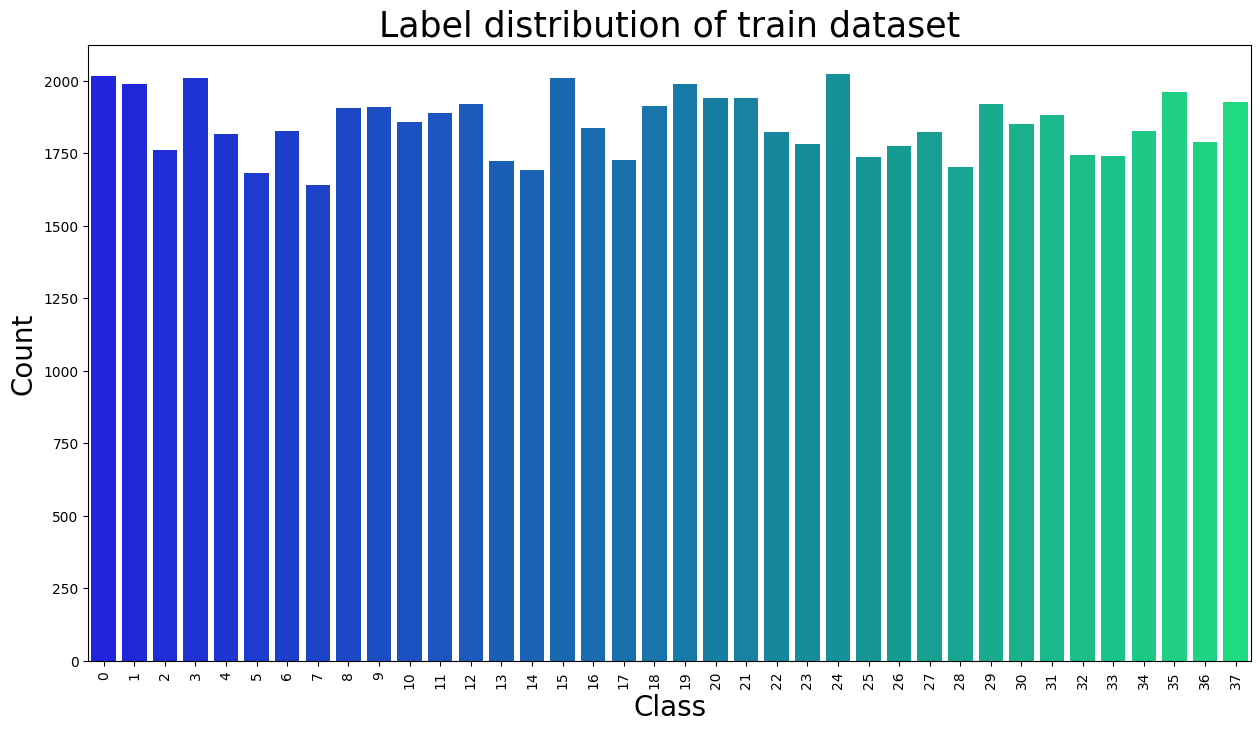

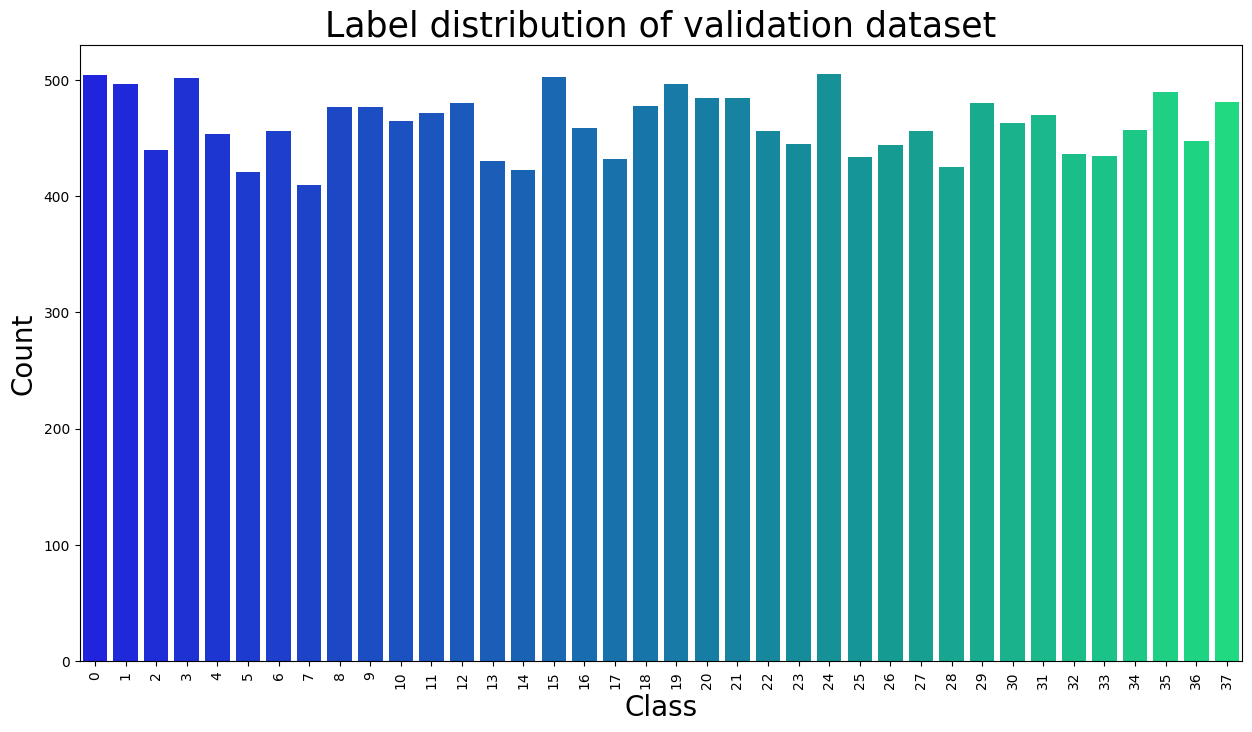

9406464/9406464 [==============================] - 1s 0us/step
Epoch 1/5
2197/2197 [==============================] - 945s 425ms/step - loss: 0.8425 - accuracy: 0.7596 - val_loss: 0.3653 - val_accuracy: 0.8893
Epoch 2/5
2197/2197 [==============================] - 922s 420ms/step - loss: 0.3630 - accuracy: 0.8857 - val_loss: 0.2615 - val_accuracy: 0.9206
Epoch 3/5
2197/2197 [==============================] - 916s 417ms/step - loss: 0.2893 - accuracy: 0.9069 - val_loss: 0.2127 - val_accuracy: 0.9333
Epoch 4/5
2197/2197 [==============================] - 912s 415ms/step - loss: 0.2481 - accuracy: 0.9194 - val_loss: 0.2155 - val_accuracy: 0.9297
Epoch 5/5
2197/2197 [==============================] - 920s 419ms/step - loss: 0.2239 - accuracy: 0.9256 - val_loss: 0.1793 - val_accuracy: 0.9410


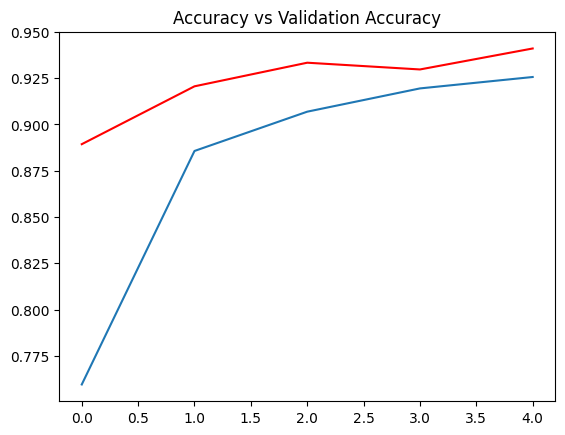

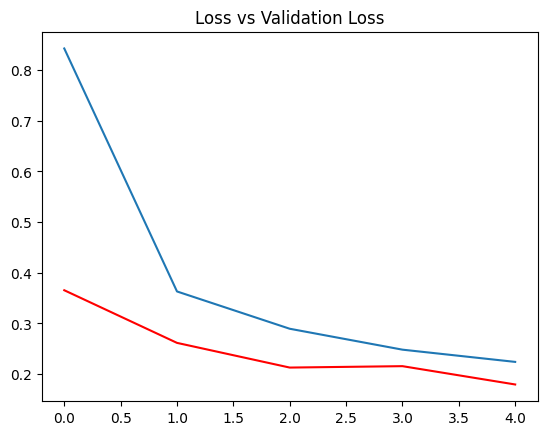

In [16]:
# Main function
def main():
  train_generator, val_generator = load_data()
  eda(train_generator, val_generator)
  model = create_model(train_generator)
  history = train_model(model, train_generator, val_generator)
  save_model(model, MODEL_PATH)
  plot_history(history)

# Run the main function
if __name__ == "__main__":
    main()